In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from IPython import display


In [3]:
train_dir = '/content/drive/MyDrive/CSCI_6967/HW5/datasplits/train'

IMG_HEIGHT = 64
IMG_WIDTH  = 64
BATCH_SIZE = 32

# Create a tf.data.Dataset for the train split
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode=None,  # No labels for VAE
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Normalize images to [0, 1]
def normalize_img(images):
    return tf.cast(images, tf.float32) / 255.0

train_dataset = train_dataset.map(normalize_img)


Found 6352 files.


In [4]:
class Sampling(tf.keras.layers.Layer):
    """
    Samples (z) from the latent distribution using
    z = mean + exp(logvar * 0.5) * epsilon,
    where epsilon ~ N(0,1).
    """
    def call(self, inputs):
        mean, logvar = inputs
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * logvar) * epsilon


In [5]:
LATENT_DIM = 64  # Size of the latent representation

# Encoder
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim=LATENT_DIM):
        super(Encoder, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_logvar = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        mean = self.dense_mean(x)
        logvar = self.dense_logvar(x)
        z = self.sampling((mean, logvar))
        return z, mean, logvar

# Decoder
class Decoder(tf.keras.Model):
    def __init__(self, latent_dim=LATENT_DIM):
        super(Decoder, self).__init__()
        # Increase or adjust these layers if using larger images
        self.dense = tf.keras.layers.Dense(units=8*8*128, activation='relu')
        self.reshape_layer = tf.keras.layers.Reshape(target_shape=(8, 8, 128))
        self.deconv1 = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')
        self.deconv2 = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')
        # Final layer has 3 channels for RGB; no activation -> raw logits
        self.deconv3 = tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same')

    def call(self, z):
        x = self.dense(z)
        x = self.reshape_layer(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)  # output shape ~ (batch, 64, 64, 3)
        return x


In [6]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim=LATENT_DIM):
        super(CVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(16, LATENT_DIM))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        z, mean, logvar = self.encoder(x)
        return z, mean, logvar

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        return logits


In [7]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    """
    Computes log probability of `sample` under a normal distribution
    parameterized by `mean` and `logvar`.
    """
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -0.5 * (logvar + tf.square(sample - mean) / tf.exp(logvar) + log2pi),
        axis=raxis
    )

def compute_loss(model, x):
    z, mean, logvar = model.encode(x)
    x_logit = model.decode(z)
    # Reconstruction loss (Bernoulli / cross-entropy)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_logit)
    # Sum over spatial dimensions and color channels
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    # KL divergence
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


Epoch: 1, Loss: 8404.8535, Time: 12.75s


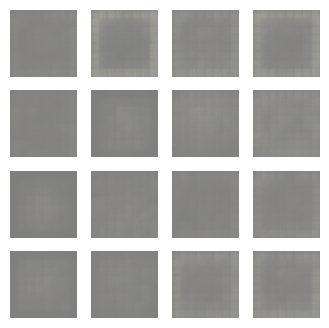

Epoch: 2, Loss: 7765.2754, Time: 7.59s


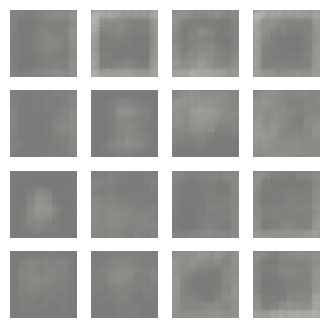

Epoch: 3, Loss: 7294.6357, Time: 7.66s


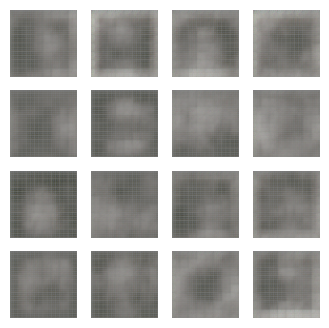

Epoch: 4, Loss: 6860.9199, Time: 7.73s


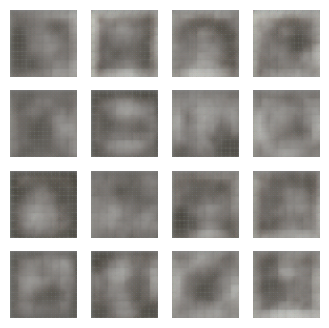

Epoch: 5, Loss: 6095.7485, Time: 7.74s


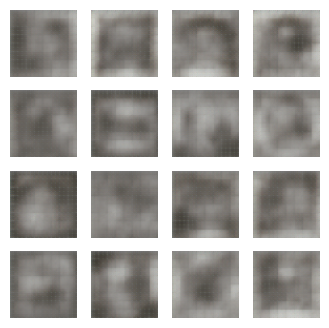

Epoch: 6, Loss: 6456.6221, Time: 7.38s


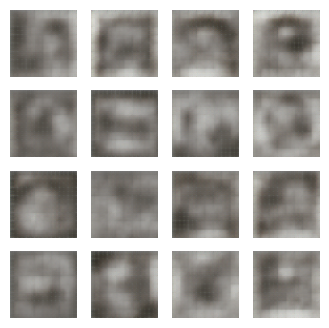

Epoch: 7, Loss: 6632.5645, Time: 7.77s


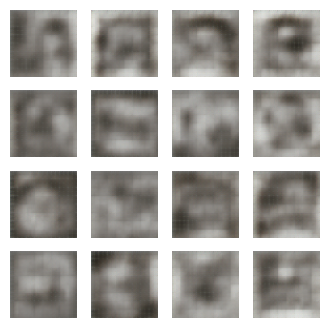

Epoch: 8, Loss: 6556.9326, Time: 7.86s


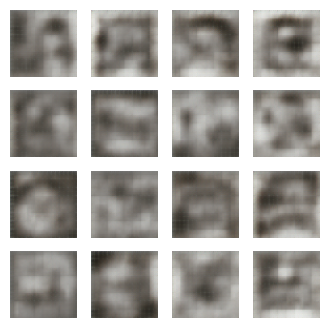

Epoch: 9, Loss: 6596.8550, Time: 7.68s


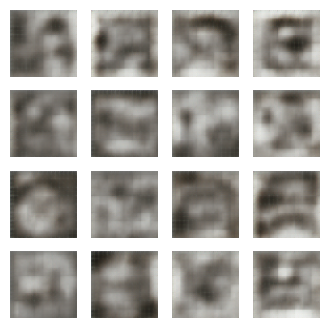

Epoch: 10, Loss: 7056.9795, Time: 7.67s


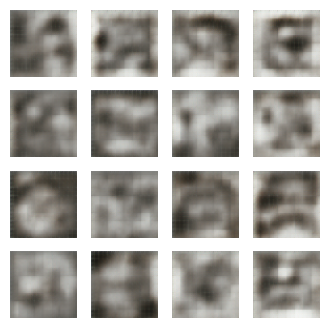

Epoch: 11, Loss: 6949.4858, Time: 7.78s


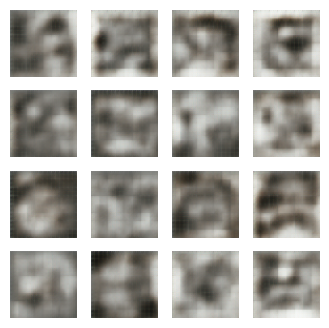

Epoch: 12, Loss: 6632.5361, Time: 7.59s


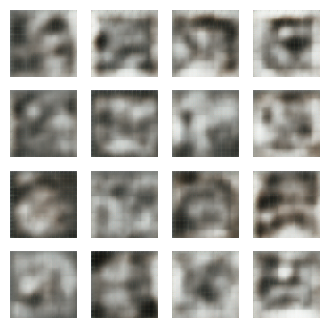

Epoch: 13, Loss: 6612.8252, Time: 7.73s


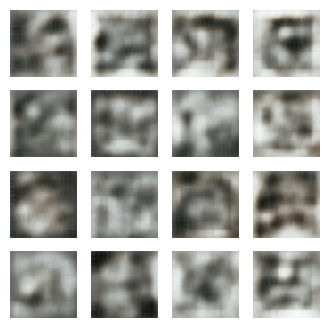

Epoch: 14, Loss: 6221.2437, Time: 7.77s


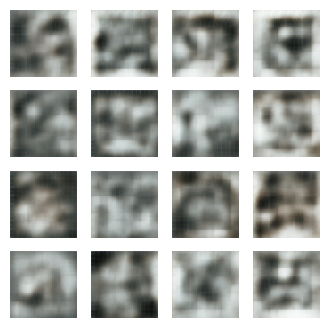

Epoch: 15, Loss: 6766.8018, Time: 7.53s


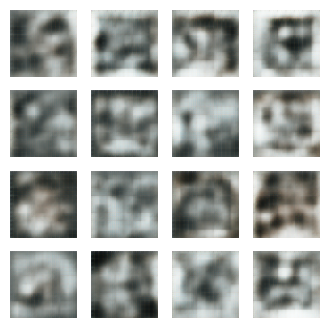

Epoch: 16, Loss: 6569.8301, Time: 7.95s


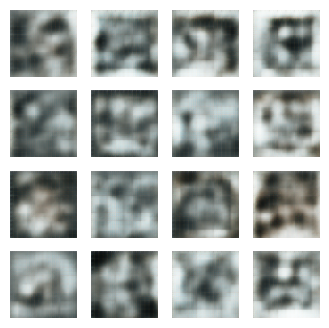

Epoch: 17, Loss: 6450.1934, Time: 7.77s


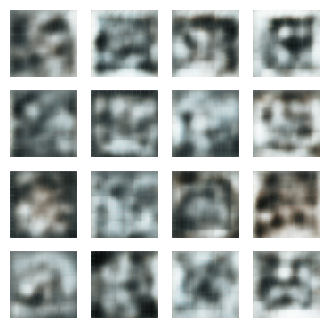

Epoch: 18, Loss: 6672.5718, Time: 7.44s


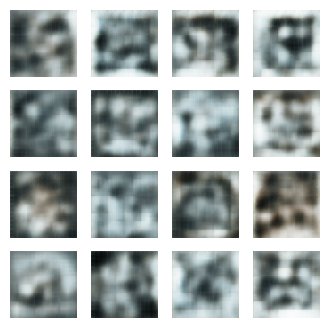

Epoch: 19, Loss: 6238.1724, Time: 7.97s


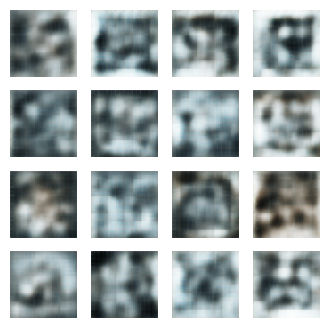

Epoch: 20, Loss: 6094.4170, Time: 7.99s


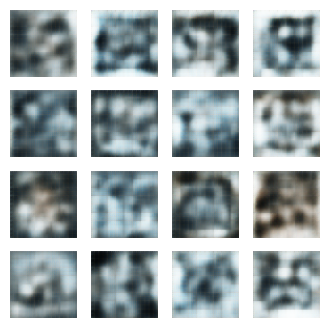

Epoch: 21, Loss: 5752.6807, Time: 7.52s


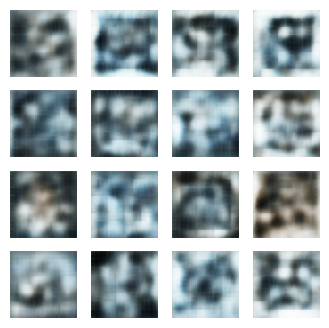

Epoch: 22, Loss: 5851.5400, Time: 7.70s


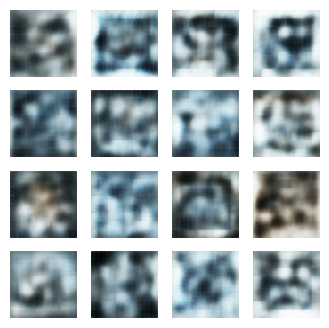

Epoch: 23, Loss: 6414.3472, Time: 7.72s


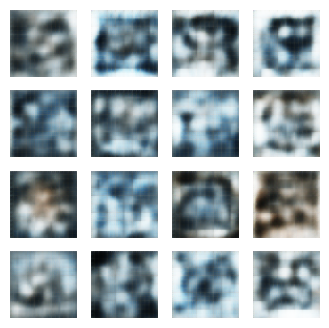

Epoch: 24, Loss: 6129.6489, Time: 7.54s


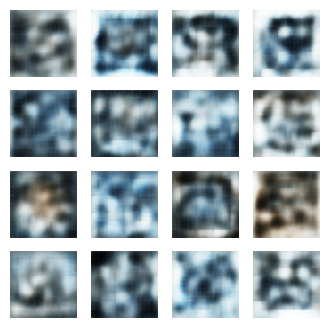

Epoch: 25, Loss: 6061.5068, Time: 7.78s


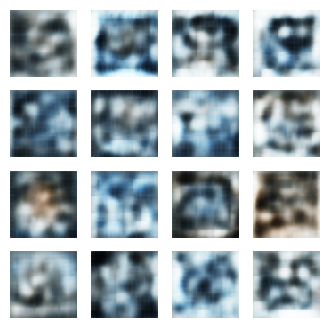

Epoch: 26, Loss: 6181.3442, Time: 7.89s


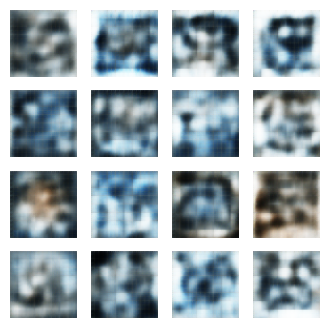

Epoch: 27, Loss: 6703.2295, Time: 8.02s


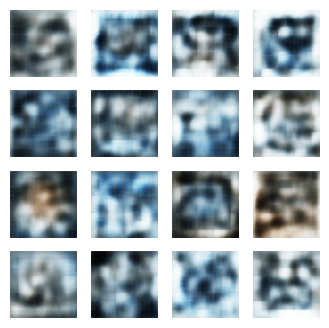

Epoch: 28, Loss: 6464.3203, Time: 7.82s


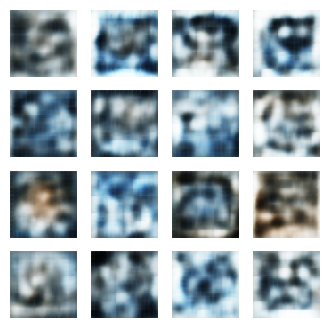

Epoch: 29, Loss: 5872.9717, Time: 7.70s


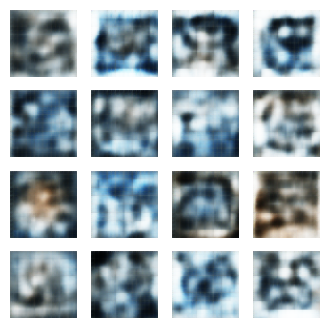

Epoch: 30, Loss: 6789.0049, Time: 7.61s


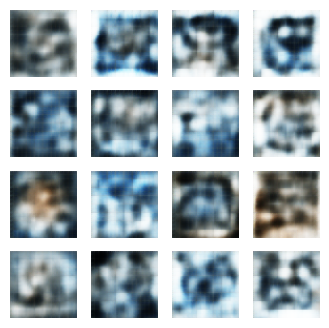

Epoch: 31, Loss: 5814.1357, Time: 7.72s


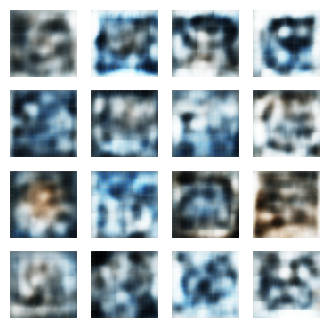

Epoch: 32, Loss: 6132.0640, Time: 7.82s


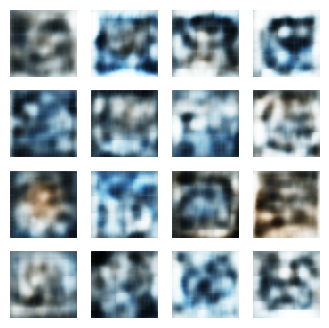

Epoch: 33, Loss: 6201.1602, Time: 8.04s


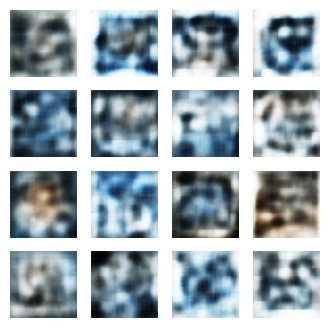

Epoch: 34, Loss: 6462.1582, Time: 7.67s


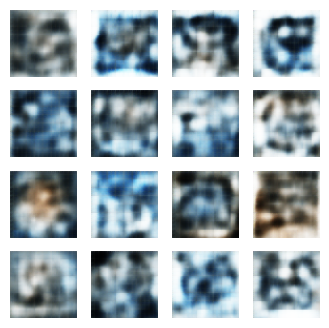

Epoch: 35, Loss: 5996.3740, Time: 7.65s


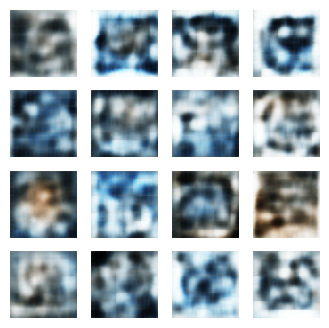

Epoch: 36, Loss: 6174.5693, Time: 8.26s


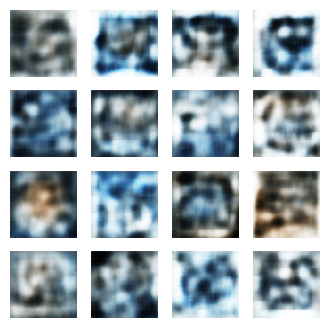

Epoch: 37, Loss: 6255.1743, Time: 7.87s


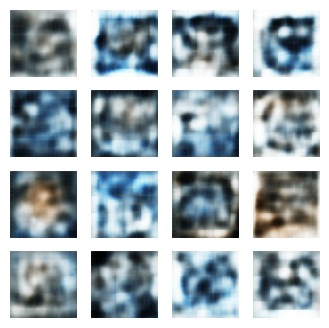

Epoch: 38, Loss: 6123.1543, Time: 7.70s


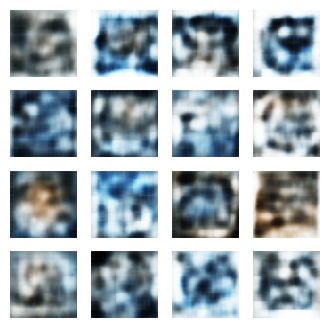

Epoch: 39, Loss: 5903.5454, Time: 7.68s


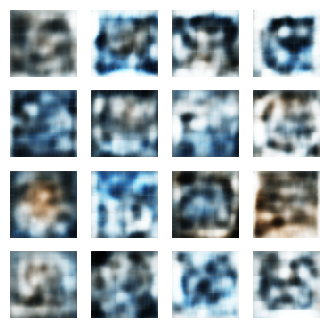

Epoch: 40, Loss: 5836.3955, Time: 7.83s


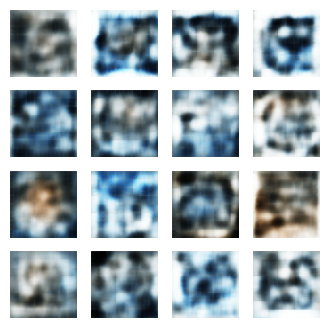

Epoch: 41, Loss: 6322.2061, Time: 7.72s


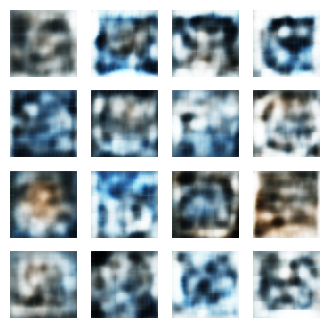

Epoch: 42, Loss: 6776.4360, Time: 7.60s


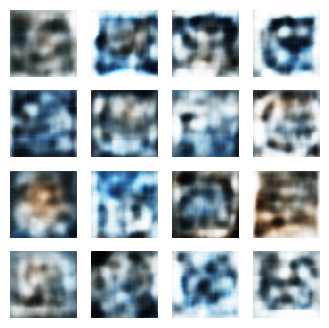

Epoch: 43, Loss: 5981.4365, Time: 7.71s


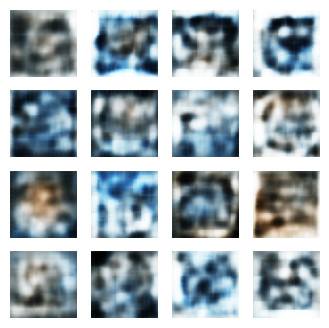

Epoch: 44, Loss: 6175.4941, Time: 7.57s


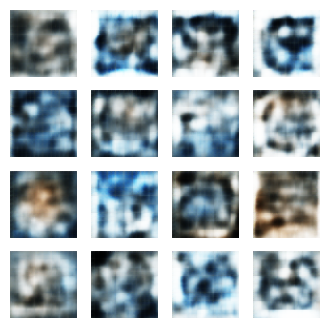

Epoch: 45, Loss: 5996.5874, Time: 8.03s


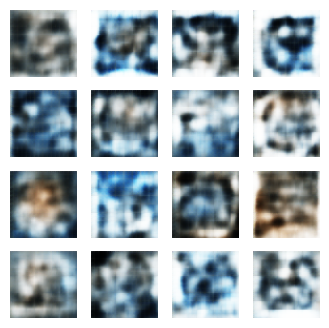

Epoch: 46, Loss: 6127.5059, Time: 7.92s


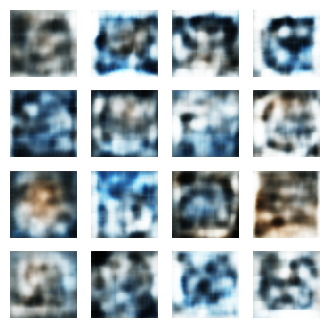

Epoch: 47, Loss: 6038.0596, Time: 7.68s


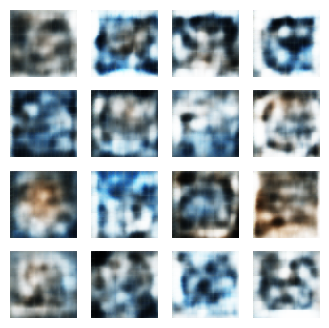

Epoch: 48, Loss: 5348.3760, Time: 7.73s


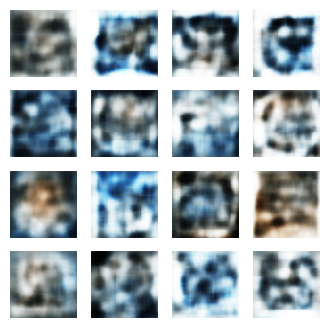

Epoch: 49, Loss: 6924.4219, Time: 7.82s


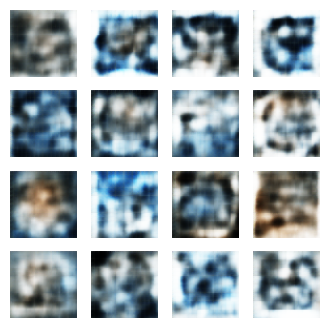

Epoch: 50, Loss: 6005.5981, Time: 7.73s


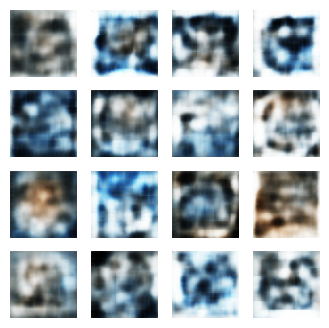

In [9]:
EPOCHS = 50
cvae = CVAE(latent_dim=LATENT_DIM)

# For plotting results
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # Clip to [0,1] since output can be out of bounds
        plt.imshow(tf.clip_by_value(predictions[i], 0., 1.0))
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:02d}.png')
    plt.show()

# Random vector for checking generation progress
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

for epoch in range(1, EPOCHS+1):
    start_time = time.time()
    for train_x in train_dataset:
        loss = train_step(cvae, train_x, optimizer)
    end_time = time.time()

    # Display loss and generate samples
    print(f"Epoch: {epoch}, Loss: {loss.numpy():.4f}, Time: {end_time - start_time:.2f}s")

    # Generate images from the VAE
    generate_and_save_images(cvae, epoch, random_vector_for_generation)


# Part 2

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from IPython import display

print("TensorFlow version:", tf.__version__)

# Hyperparameters
IMG_HEIGHT = 64
IMG_WIDTH  = 64
CHANNELS   = 3
BATCH_SIZE = 32
LATENT_DIM = 100   # Size of random noise vector
EPOCHS = 50        # Adjust based on your dataset size
NUM_EXAMPLES_TO_GENERATE = 16


TensorFlow version: 2.18.0


In [11]:
train_dir = '/content/drive/MyDrive/CSCI_6967/HW5/datasplits/train'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode=None,           # No labels needed for GANs
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Convert [0,1] range -> [-1,1] range
def normalize_img(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1.0
    return image

train_dataset = train_dataset.map(lambda x: normalize_img(x))
# Repeat and prefetch for performance
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Found 6352 files.


In [12]:
def make_generator_model():
    model = tf.keras.Sequential()

    # FC layer to expand the latent vector
    model.add(tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    # Now shape is (8, 8, 256)

    # Upsample to 16x16
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    # Shape: (16, 16, 128)

    # Upsample to 32x32
    model.add(tf.keras.layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    # Shape: (32, 32, 64)

    # Upsample to 64x64
    model.add(tf.keras.layers.Conv2DTranspose(CHANNELS, (4,4), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    # Shape: (64, 64, 3)

    return model

generator = make_generator_model()
generator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 16384)               │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 64, 64, 3)           │           3,072 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,363,136 (9.01 MB)

 Trainable params: 2,329,984 (8.89 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same',
                                     input_shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))
    # Shape: (32, 32, 64)

    model.add(tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))
    # Shape: (16, 16, 128)

    model.add(tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))
    # Shape: (8, 8, 256)

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │          16,385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 675,265 (2.58 MB)

 Trainable params: 675,265 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # real_output => should be all ones
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # fake_output => should be all zeros
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    # fake_output classified as real
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [15]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [16]:
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, LATENT_DIM])

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    # predictions in [-1, 1], shift them back to [0,1] for plotting
    predictions = (predictions + 1) / 2.0

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i].numpy())
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.tight_layout()
    plt.show()


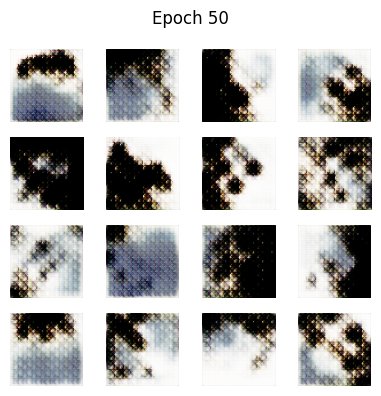

In [17]:
def train(dataset, epochs):
    for epoch in range(1, epochs+1):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch, seed)

        print (f'Epoch {epoch}, '
               f'Generator Loss: {gen_loss:.4f}, '
               f'Discriminator Loss: {disc_loss:.4f}, '
               f'Time: {time.time()-start:.2f} sec')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

# Run the training
train(train_dataset, EPOCHS)
